d:\Agentic AI Projects\Self Rag\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 103/103 [00:00<00:00, 249.58it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


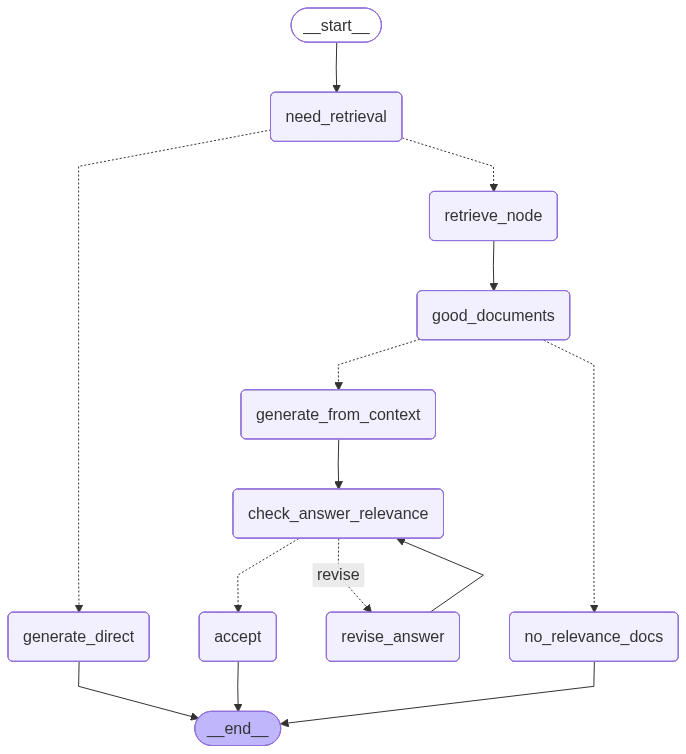

In [1]:
from typing import List, TypedDict, Literal
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel , Field
from dotenv import load_dotenv

load_dotenv()

llm = ChatGroq(model="openai/gpt-oss-120b")
emb = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

database = FAISS.load_local(
    "faiss_index_database",
    emb,
    allow_dangerous_deserialization=True
)

retriever = database.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}
)

class State(TypedDict):
    question: str
    to_retrieve: bool
    docs: List[Document]
    answer: str
    good_docs: List[Document]
    context: str
    retry : int
    is_supported: Literal["Fully Supported", "Partially Supported", "Not Supported"]

# ---------------- RETRIEVAL DECISION ---------------- #

def need_retrieval(state: State) -> State:

    class RetrievalDecision(BaseModel):
        need: bool

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a strict routing classifier.\n"
                "Your job is to decide whether the question requires document retrieval.\n\n"
                "Return need=True if:\n"
                "- The question asks about specific research papers\n"
                "- The question refers to Self-RAG, Corrective-RAG, or RAG variants\n"
                "- The question requires specific factual grounding\n\n"
                "Return need=False if:\n"
                "- The question can be answered using general knowledge\n\n"
                "Output JSON only."
            ),
            ("human", "Question: {question}")
        ]
    )

    chain = prompt | llm.with_structured_output(RetrievalDecision)
    result = chain.invoke({"question": state["question"]})

    return {"to_retrieve": result.need}

# ---------------- RETRIEVE ---------------- #

def retrieve_node(state: State) -> State:
    docs = retriever.invoke(state["question"])
    return {"docs": docs}

# ---------------- FILTER GOOD DOCS ---------------- #

def good_documents(state: State) -> State:

    class Relevance(BaseModel):
        is_good: bool

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a strict document relevance evaluator.\n"
                "A document is relevant ONLY if it directly contains information\n"
                "that helps answer the question.\n"
                "If it only mentions related concepts but does not help answer,\n"
                "return is_good=False.\n"
                "Be very strict.\n"
                "Output JSON only."
            ),
            ("human", "Question: {question}\n\nDocument:\n{document}")
        ]
    )

    chain = prompt | llm.with_structured_output(Relevance)

    good_docs = []

    for d in state["docs"]:
        result = chain.invoke(
            {"question": state["question"], "document": d.page_content}
        )
        if result.is_good:
            good_docs.append(d)

    return {"good_docs": good_docs}

# ---------------- GENERATE FROM CONTEXT ---------------- #

def generate_from_context(state: State) -> State:

    context = "\n\n".join([d.page_content for d in state["good_docs"]])

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You must answer ONLY using the provided context.\n"
                "Do NOT add outside knowledge.\n"
                "If the context is insufficient, say:\n"
                "'The context does not contain enough information.'"
            ),
            ("human", "Question: {question}\n\nContext:\n{context}")
        ]
    )

    chain = prompt | llm
    out = chain.invoke(
        {"question": state["question"], "context": context}
    )

    return {
        "answer": out.content,
        "context": context
    }

# ---------------- NO RELEVANT DOCS ---------------- #

def no_relevance_docs(state: State) -> State:
    return {
        "answer": "No relevant documents found to answer this question.",
        "context": ""
    }

def relevance_docs_to_generate(state: State):
    if state["good_docs"]:
        return "generate_from_context"
    else:
        return "no_relevance_docs"

# ---------------- ANSWER SUPPORT CHECK ---------------- #

def check_answer_relevance(state: State) -> State:

    class Support(BaseModel):
        issup: Literal["Fully Supported", "Partially Supported", "Not Supported"]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a hallucination detector.\n"
                "Compare answer with context strictly.\n\n"
                "Fully Supported → Every factual claim appears in context.\n"
                "Partially Supported → Some claims appear, others do not.\n"
                "Not Supported → Claims are not grounded in context.\n\n"
                "Be extremely strict.\n"
                "Output JSON only."
            ),
            (
                "human",
                "Question: {question}\n\nContext:\n{context}\n\nAnswer:\n{answer}"
            )
        ]
    )

    chain = prompt | llm.with_structured_output(Support)

    result = chain.invoke(
        {
            "question": state["question"],
            "context": state["context"],
            "answer": state["answer"]
        }
    )

    return {"is_supported": result.issup}


def revise_answer(state: State) -> State:
    class Revise(BaseModel):
        r : str = Field(description="The answer to the given question.")
        
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a great answer reviser.\n"
                "You will be given with one question, one answer and a retrieved context\n\n"
                "The answer is getting hallucinations.\n"
                "So you need to rewrite the answer based on the given context only.\n"
                "Don't include the information other than the retrieved context.\n\n"
                "Be extremely strict.\n"
                "Output JSON only."
            ),
            (
                "human",
                "Question: {question}\n\nContext:\n{context}\n\nAnswer:\n{answer}"
            )
        ]
    )

    chain = prompt | llm.with_structured_output(Revise)

    result = chain.invoke(
        {
            "question": state["question"],
            "context": state["context"],
            "answer": state["answer"]
        }
    )

    return {
        "answer" : result.r,
        "retry" : state["retry"] + 1
    }

def route_to_rwrite(state: State):
    if state["is_supported"] == "Fully Supported":
        return "accept"
    
    if state["retry"] == 5:
        return "accept"
    
    return "revise"


def accept(state: State):
    return  {}


# ---------------- DIRECT GENERATION ---------------- #

def generate_direct(state: State) -> State:

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "Answer using only general knowledge.\n"
                "If unsure, say:\n"
                "'I don't know based on my general knowledge.'"
            ),
            ("human", "{question}")
        ]
    )

    out = llm.invoke(
        prompt.format_messages(question=state["question"])
    )

    return {"answer": out.content}

# ---------------- ROUTING ---------------- #

def condition(state: State):
    if state["to_retrieve"]:
        return "retrieve_node"
    return "generate_direct"

# ---------------- GRAPH ---------------- #

graph = StateGraph(State)

graph.add_node("need_retrieval", need_retrieval)
graph.add_node("generate_direct", generate_direct)
graph.add_node("retrieve_node", retrieve_node)
graph.add_node("good_documents", good_documents)
graph.add_node("generate_from_context", generate_from_context)
graph.add_node("no_relevance_docs", no_relevance_docs)
graph.add_node("check_answer_relevance", check_answer_relevance)
graph.add_node("revise_answer" , revise_answer)
graph.add_node("accept" , accept)


graph.add_edge(START, "need_retrieval")

graph.add_conditional_edges(
    "need_retrieval",
    condition,
    {
        "retrieve_node": "retrieve_node",
        "generate_direct": "generate_direct"
    }
)

graph.add_edge("generate_direct", END)
graph.add_edge("retrieve_node", "good_documents")

graph.add_conditional_edges(
    "good_documents",
    relevance_docs_to_generate,
    {
        "generate_from_context": "generate_from_context",
        "no_relevance_docs": "no_relevance_docs"
    }
)

graph.add_edge("generate_from_context", "check_answer_relevance")

graph.add_conditional_edges("check_answer_relevance",
                            route_to_rwrite,
                            {"accept" : "accept",
                             "revise" : "revise_answer"})

graph.add_edge("accept", END)
graph.add_edge("revise_answer", "check_answer_relevance")

workflow = graph.compile()

workflow

# ---------------- RUN ---------------- #

# result = workflow.invoke(
#     {
#         "question": "What is CRAG and what is the name of the person who developed this?",
#         "docs": [],
#         "answer": "",
#         "to_retrieve": False,
#         "good_docs": [],
#         "context": "",
#         "is_supported": "Not Supported",
#         "retry" : 0
#     }
# )



# print(result["to_retrieve"])
# print(len(result["docs"]))
# print(len(result["good_docs"]))
# print(result["answer"])
# print(result.get("is_supported"))

d:\Agentic AI Projects\Self Rag\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 103/103 [00:00<00:00, 606.38it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


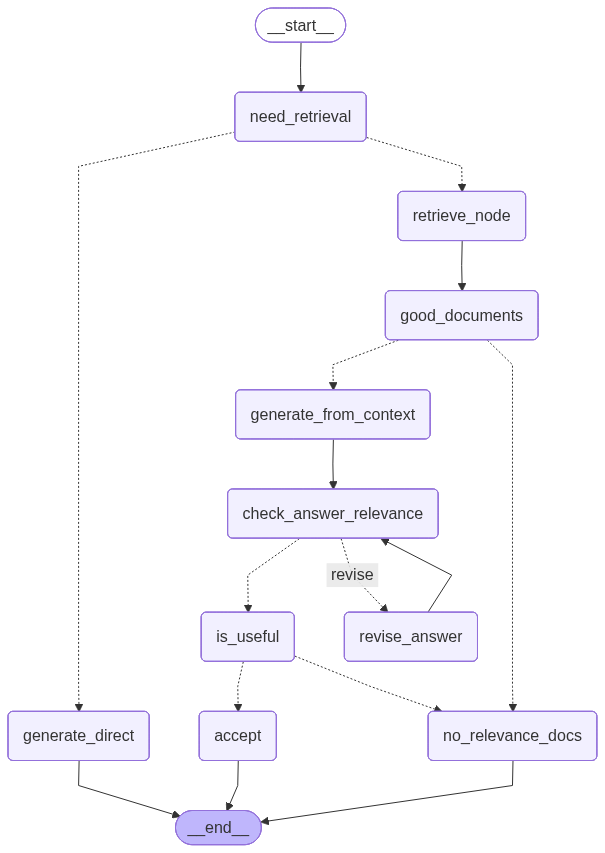

In [1]:
from typing import List, TypedDict, Literal
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel , Field
from dotenv import load_dotenv

load_dotenv()

llm = ChatGroq(model="openai/gpt-oss-120b")
emb = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

database = FAISS.load_local(
    "faiss_index_database",
    emb,
    allow_dangerous_deserialization=True
)

retriever = database.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}
)

class State(TypedDict):
    question: str
    to_retrieve: bool
    docs: List[Document]
    answer: str
    good_docs: List[Document]
    context: str
    retry : int
    is_use : bool
    is_supported: Literal["Fully Supported", "Partially Supported", "Not Supported"]

# ---------------- RETRIEVAL DECISION ---------------- #

def need_retrieval(state: State) -> State:

    class RetrievalDecision(BaseModel):
        need: bool

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a strict routing classifier.\n"
                "Your job is to decide whether the question requires document retrieval.\n\n"
                "Return need=True if:\n"
                "- The question asks about specific research papers\n"
                "- The question refers to Self-RAG, Corrective-RAG, or RAG variants\n"
                "- The question requires specific factual grounding\n\n"
                "Return need=False if:\n"
                "- The question can be answered using general knowledge\n\n"
                "Output JSON only."
            ),
            ("human", "Question: {question}")
        ]
    )

    chain = prompt | llm.with_structured_output(RetrievalDecision)
    result = chain.invoke({"question": state["question"]})

    return {"to_retrieve": result.need}

# ---------------- RETRIEVE ---------------- #

def retrieve_node(state: State) -> State:
    docs = retriever.invoke(state["question"])
    return {"docs": docs}

# ---------------- FILTER GOOD DOCS ---------------- #

def good_documents(state: State) -> State:

    class Relevance(BaseModel):
        is_good: bool

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a strict document relevance evaluator.\n"
                "A document is relevant ONLY if it directly contains information\n"
                "that helps answer the question.\n"
                "If it only mentions related concepts but does not help answer,\n"
                "return is_good=False.\n"
                "Be very strict.\n"
                "Output JSON only."
            ),
            ("human", "Question: {question}\n\nDocument:\n{document}")
        ]
    )

    chain = prompt | llm.with_structured_output(Relevance)

    good_docs = []

    for d in state["docs"]:
        result = chain.invoke(
            {"question": state["question"], "document": d.page_content}
        )
        if result.is_good:
            good_docs.append(d)

    return {"good_docs": good_docs}

# ---------------- GENERATE FROM CONTEXT ---------------- #

def generate_from_context(state: State) -> State:

    context = "\n\n".join([d.page_content for d in state["good_docs"]])

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You must answer ONLY using the provided context.\n"
                "Do NOT add outside knowledge.\n"
                "If the context is insufficient, say:\n"
                "'The context does not contain enough information.'"
            ),
            ("human", "Question: {question}\n\nContext:\n{context}")
        ]
    )

    chain = prompt | llm
    out = chain.invoke(
        {"question": state["question"], "context": context}
    )

    return {
        "answer": out.content,
        "context": context
    }

# ---------------- NO RELEVANT DOCS ---------------- #

def no_relevance_docs(state: State) -> State:
    return {
        "answer": "No relevant documents found to answer this question.",
        "context": ""
    }

def relevance_docs_to_generate(state: State):
    if state["good_docs"]:
        return "generate_from_context"
    else:
        return "no_relevance_docs"

# ---------------- ANSWER SUPPORT CHECK ---------------- #

def check_answer_relevance(state: State) -> State:

    class Support(BaseModel):
        issup: Literal["Fully Supported", "Partially Supported", "Not Supported"]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a hallucination detector.\n"
                "Compare answer with context strictly.\n\n"
                "Fully Supported → Every factual claim appears in context.\n"
                "Partially Supported → Some claims appear, others do not.\n"
                "Not Supported → Claims are not grounded in context.\n\n"
                "Be extremely strict.\n"
                "Output JSON only."
            ),
            (
                "human",
                "Question: {question}\n\nContext:\n{context}\n\nAnswer:\n{answer}"
            )
        ]
    )

    chain = prompt | llm.with_structured_output(Support)

    result = chain.invoke(
        {
            "question": state["question"],
            "context": state["context"],
            "answer": state["answer"]
        }
    )

    return {"is_supported": result.issup}


def revise_answer(state: State) -> State:
    class Revise(BaseModel):
        r : str = Field(description="The answer to the given question.")
        
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a great answer reviser.\n"
                "You will be given with one question, one answer and a retrieved context\n\n"
                "The answer is getting hallucinations.\n"
                "So you need to rewrite the answer based on the given context only.\n"
                "Don't include the information other than the retrieved context.\n\n"
                "Be extremely strict.\n"
                "Output JSON only."
            ),
            (
                "human",
                "Question: {question}\n\nContext:\n{context}\n\nAnswer:\n{answer}"
            )
        ]
    )

    chain = prompt | llm.with_structured_output(Revise)

    result = chain.invoke(
        {
            "question": state["question"],
            "context": state["context"],
            "answer": state["answer"]
        }
    )

    return {
        "answer" : result.r,
        "retry" : state["retry"] + 1
    }

def route_to_rwrite(state: State):
    if state["is_supported"] == "Fully Supported":
        return "is_useful"
    
    if state["retry"] == 5:
        return "is_useful"
    
    return "revise"


def accept(state: State):
    return  {}

def is_useful(state: State) -> State:
    class Useful(BaseModel):
        isuse : bool
        
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an answer evaluator\n",
                "You will receive the question and it's answer\n",
                "If the answer is useful for that specific questions you have to return isuse=True\n",
                "Otherwise return isuse=False\n"
                "Be extremely strict.\n"
                "Output JSON only."
            ),
            (
                "human",
                "Question: {question}\n\nAnswer:\n{answer}"
            )
        ]
    )

    chain = prompt | llm.with_structured_output(Useful)

    result = chain.invoke(
        {
            "question": state["question"],
            "answer": state["answer"]
        }
    )
    return {"is_use" :  result.isuse}

def route_to_useful(state: State):
    if state["is_use"]:
        return "accept"
    else:
        return "no_relevance_docs"


# ---------------- DIRECT GENERATION ---------------- #

def generate_direct(state: State) -> State:

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "Answer using only general knowledge.\n"
                "If unsure, say:\n"
                "'I don't know based on my general knowledge.'"
            ),
            ("human", "{question}")
        ]
    )

    out = llm.invoke(
        prompt.format_messages(question=state["question"])
    )

    return {"answer": out.content}

# ---------------- ROUTING ---------------- #

def condition(state: State):
    if state["to_retrieve"]:
        return "retrieve_node"
    return "generate_direct"

# ---------------- GRAPH ---------------- #

graph = StateGraph(State)

graph.add_node("need_retrieval", need_retrieval)
graph.add_node("generate_direct", generate_direct)
graph.add_node("retrieve_node", retrieve_node)
graph.add_node("good_documents", good_documents)
graph.add_node("generate_from_context", generate_from_context)
graph.add_node("no_relevance_docs", no_relevance_docs)
graph.add_node("check_answer_relevance", check_answer_relevance)
graph.add_node("revise_answer" , revise_answer)
graph.add_node("accept" , accept)
graph.add_node("is_useful" , is_useful)


graph.add_edge(START, "need_retrieval")

graph.add_conditional_edges(
    "need_retrieval",
    condition,
    {
        "retrieve_node": "retrieve_node",
        "generate_direct": "generate_direct"
    }
)

graph.add_edge("generate_direct", END)
graph.add_edge("retrieve_node", "good_documents")

graph.add_conditional_edges(
    "good_documents",
    relevance_docs_to_generate,
    {
        "generate_from_context": "generate_from_context",
        "no_relevance_docs": "no_relevance_docs"
    }
)

graph.add_edge("generate_from_context", "check_answer_relevance")

graph.add_conditional_edges("check_answer_relevance",
                            route_to_rwrite,
                            {"is_useful" : "is_useful",
                             "revise" : "revise_answer"})


graph.add_conditional_edges("is_useful",
                            route_to_useful,
                            {"accept" : "accept",
                             "no_relevance_docs" : "no_relevance_docs"})
graph.add_edge("is_useful", "accept")
graph.add_edge("accept" , END)
graph.add_edge("no_relevance_docs" , END)
graph.add_edge("revise_answer", "check_answer_relevance")

workflow = graph.compile()

workflow